In [17]:
#Preprocessing and Visualization #
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder, LabelEncoder


#Feature selection & Model selection#
from sklearn.feature_selection import SelectFromModel,RFE,SelectKBest, f_classif
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV,RandomizedSearchCV,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.svm import SVC
import lightgbm as lgb
import csv

#Metrics
from sklearn.metrics import cohen_kappa_score,f1_score,accuracy_score,confusion_matrix,recall_score,precision_score,classification_report,ConfusionMatrixDisplay

#To handle warnings
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning, module='sklearn')


In [3]:
# To load dataset from Kaggle. Click on Add Data->Search for Arrhythmia-ECG  Dataset from UCI->
#Copy the CSV file path under Input and paste it here

data = pd.read_csv("/kaggle/input/arrhythmia-ecg-dataset-from-uci/arrhythmia.csv")

# to load dataset from Google Collab
#filepath='/content/sample_data/arrhythmia.csv'
#data=pd.read_csv(filepath)


In [3]:
data.shape


(452, 280)

In [4]:
data.isna().sum().sort_values(ascending=False)

J                             376
P                              22
T                               8
QRST                            1
heartrate                       1
                             ... 
chV2_RPwave                     0
chV2_SPwave                     0
chV2_intrinsicReflecttions      0
chV2_RRwaveExists               0
class                           0
Length: 280, dtype: int64

In [4]:
##Missing Value Imputation Method 2
##KNN imputer
KNNimputer=KNNImputer(n_neighbors=5)
KNNimputeddata=KNNimputer.fit_transform(data)

KNNimputedDF=pd.DataFrame(KNNimputeddata)

# Imputation outcome
KNNimputedDF.isnull().sum().sort_values(ascending=False)

KNNimputedDF.columns=data.columns
#print(KNNimputedDF)





In [5]:
## Check that all missing values are imputed 
KNNimputedDF.isnull().sum().sort_values(ascending=False)

age                 0
chDIII_SPwaveAmp    0
chAVR_QwaveAmp      0
chAVR_JJwaveAmp     0
chDIII_QRSTA        0
                   ..
chV2_Qwave          0
chV2_Rwave          0
chV2_Swave          0
chV2_RPwave         0
class               0
Length: 280, dtype: int64

In [5]:
#Split the features and target
x = KNNimputedDF.drop("class", axis=1)
y = KNNimputedDF["class"]
print(x.shape)


(452, 279)


In [6]:
## feature selection using kbest##
kbestselector = SelectKBest(f_classif, k=94)
newdata=kbestselector.fit(x,y)

selected_features_df = pd.DataFrame({'Feature':list(x.columns),
                                     'Scores':kbestselector.scores_})
temp= selected_features_df.sort_values(by='Scores', ascending=False)
print(temp)

# Define the range bounds
min_value = 10  # Replace with the desired minimum value
max_value = 110  # Replace with the desired maximum value

# Extract the scores within the specified range
scores_within_range = temp[(temp['Scores'] >= min_value) & (temp['Scores'] <= max_value)]
print(scores_within_range.count())


kbestfeatures=kbestselector.transform(x)
print(kbestfeatures.shape)

# Get the selected feature names
mask= kbestselector.get_support()
feature_names = x.columns.values[mask]
print(feature_names)

               Feature      Scores
111         chV3_Qwave  101.513976
240      chV3_QwaveAmp   60.556533
148         chV6_Rwave   35.977604
237          chV2_QRSA   33.082987
4          QRSduration   32.220283
..                 ...         ...
157  chV6_RTwaveExists         NaN
164     chDI_SPwaveAmp         NaN
204    chAVL_SPwaveAmp         NaN
264     chV5_SPwaveAmp         NaN
274     chV6_SPwaveAmp         NaN

[279 rows x 2 columns]
Feature    55
Scores     55
dtype: int64
(452, 94)
['QRSduration' 'Q-Tinterval' 'Tinterval' 'Pinterval' 'J' 'heartrate'
 'chDI_Rwave' 'chDI_intrinsicReflecttions' 'chDII_Qwave' 'chDII_Rwave'
 'chDII_RPwave' 'chDII_intrinsicReflecttions' 'chDIII_Swave' 'chAVR_Qwave'
 'chAVR_Rwave' 'chAVL_Rwave' 'chAVL_intrinsicReflecttions' 'chAVF_Qwave'
 'chAVF_Swave' 'chV1_Qwave' 'chV1_Rwave' 'chV1_RPwave'
 'chV1_intrinsicReflecttions' 'chV2_Qwave' 'chV2_Rwave' 'chV2_Swave'
 'chV2_RPwave' 'chV2_intrinsicReflecttions' 'chV2_RPwaveExists'
 'chV3_Qwave' 'chV3_Rwave' 'c

/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 19  67  69  83 131 132 139 141 143 145 151 156 157 164 204 264 274] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [7]:
# split the dataset, create 2 splits
#one with 80:20 and another one with 90:10
x_train, x_test,y_train,y_test=train_test_split(kbestfeatures,y,test_size=0.2,random_state=2, stratify=y)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

#90:10 split
x_train1, x_test1,y_train1,y_test1=train_test_split(kbestfeatures,y,test_size=0.1,random_state=2, stratify=y)
print(x_train1.shape,x_test1.shape,y_train1.shape,y_test1.shape)

(361, 94) (91, 94) (361,) (91,)
(406, 94) (46, 94) (406,) (46,)


In [8]:
# Normalization

scaler= StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.fit_transform(x_test)

scaler= StandardScaler()
x_train1=scaler.fit_transform(x_train1)
x_test1=scaler.fit_transform(x_test1)

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuacy of SVM: 75.82417582417582
Accuacy of MLP: 75.82417582417582
Accuacy of KNN: 64.83516483516483
Accuacy of RFC: 79.12087912087912
Accuacy of NB: 54.94505494505495
Accuacy of lgbm: 81.31868131868131


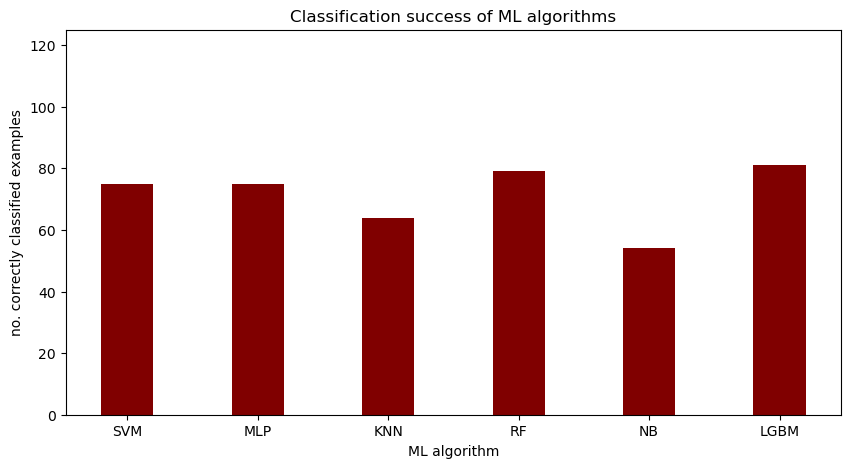

Kappa score of SVM: 0.596533655783958
Kappa score of MLP: 0.6141094834232845
Kappa score KNN: 0.36942399307059326
Kappa score RFC: 0.6644021739130435
Kappa score NB: 0.05544303797468342
Kappa score lgbm: 0.6983229329173166


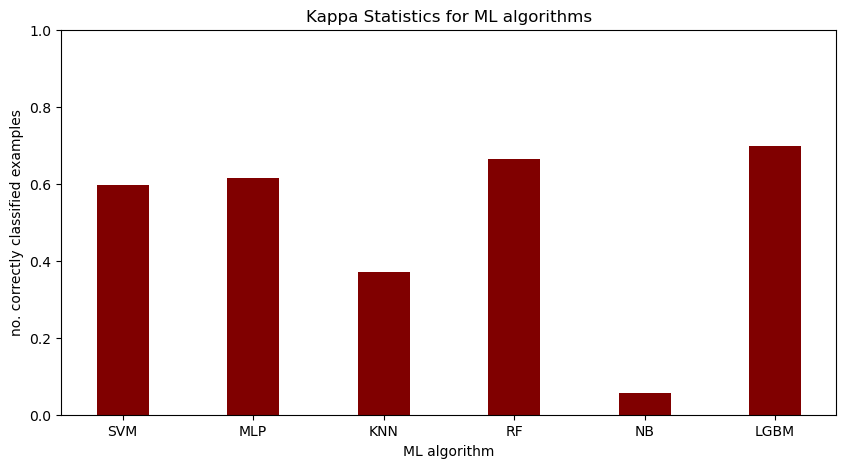

SVM_report 
               precision    recall  f1-score   support

         1.0       0.75      0.98      0.85        49
         2.0       0.80      0.44      0.57         9
         3.0       1.00      1.00      1.00         3
         4.0       0.67      0.67      0.67         3
         5.0       1.00      0.67      0.80         3
         6.0       0.00      0.00      0.00         5
         7.0       0.00      0.00      0.00         1
         9.0       1.00      0.50      0.67         2
        10.0       0.82      0.90      0.86        10
        14.0       0.00      0.00      0.00         1
        15.0       0.00      0.00      0.00         1
        16.0       0.00      0.00      0.00         4

    accuracy                           0.76        91
   macro avg       0.50      0.43      0.45        91
weighted avg       0.68      0.76      0.70        91

KNN_report 
               precision    recall  f1-score   support

         1.0       0.64      0.94      0.76        4

In [9]:
# classification models for train test split as 80:20

svm_t = SVC(C=16,kernel="rbf",gamma=0.001,random_state=42,decision_function_shape='ovo',probability=True).fit(x_train, y_train)

mlp_classifier = MLPClassifier(hidden_layer_sizes=(279), activation='tanh', solver='sgd', learning_rate='constant', random_state=42)
mlp_classifier.fit(x_train, y_train)

knn_t = KNeighborsClassifier(n_neighbors=3) .fit(x_train, y_train)

rfc_t = RandomForestClassifier(criterion= 'gini', n_estimators=100, random_state=42).fit(x_train, y_train)

lgbm_classifier = lgb.LGBMClassifier(n_estimators=100, random_state=42).fit(x_train,y_train)

nb_model = GaussianNB().fit(x_train,y_train)


svm_pred = svm_t.predict(x_test)
knn_pred = knn_t.predict(x_test)
MLP_pred = mlp_classifier.predict(x_test)
rfc_pred = rfc_t.predict(x_test)
nb_pred=nb_model.predict(x_test)
lgbm_pred=lgbm_classifier.predict(x_test)

svm_acc = accuracy_score(y_test, svm_pred)*100
knn_acc = accuracy_score(y_test, knn_pred)*100
MLP_acc=accuracy_score(y_test, MLP_pred)*100
rfc_acc = accuracy_score(y_test, rfc_pred)*100
nb_acc = accuracy_score(y_test,nb_pred)*100
lgbm_acc=accuracy_score(y_test,lgbm_pred)*100

print ("Accuacy of SVM:",svm_acc)
print("Accuacy of MLP:", MLP_acc)
print ("Accuacy of KNN:", knn_acc)
print ("Accuacy of RFC:",rfc_acc)
print("Accuacy of NB:",nb_acc)
print("Accuacy of lgbm:",lgbm_acc)

bar_data = dict()
bar_data['SVM'] = int(svm_acc)
bar_data['MLP'] = int(MLP_acc)
bar_data['KNN'] = int(knn_acc)
bar_data['RF'] = int(rfc_acc)
bar_data['NB'] = int(nb_acc)
bar_data['LGBM'] = int(lgbm_acc)


algs = list(bar_data.keys())
values = list(bar_data.values())

fig = plt.figure(figsize = (10, 5))
plt.ylim(top=125)
plt.bar(algs, values, color ='maroon',
        width = 0.4)

plt.xlabel("ML algorithm")
plt.ylabel("no. correctly classified examples")
plt.title("Classification success of ML algorithms")
plt.show()


# Kappa Statistics
svm_Kappa = cohen_kappa_score(y_test, svm_pred)
knn_kappa = cohen_kappa_score(y_test, knn_pred)
MLP_kappa=cohen_kappa_score(y_test, MLP_pred)
rfc_kappa = cohen_kappa_score(y_test, rfc_pred)
nb_kappa = cohen_kappa_score(y_test,nb_pred)
lgbm_kappa=cohen_kappa_score(y_test,lgbm_pred)

print ("Kappa score of SVM:",svm_Kappa)
print("Kappa score of MLP:", MLP_kappa)
print ("Kappa score KNN:", knn_kappa)
print ("Kappa score RFC:",rfc_kappa)
print("Kappa score NB:",nb_kappa)
print("Kappa score lgbm:",lgbm_kappa)

bar_data = dict()
bar_data['SVM'] = float(svm_Kappa)
bar_data['MLP'] = float(MLP_kappa)
bar_data['KNN'] = float(knn_kappa)
bar_data['RF'] = float(rfc_kappa)
bar_data['NB'] = float(nb_kappa)
bar_data['LGBM'] = float(lgbm_kappa)


algs = list(bar_data.keys())
values = list(bar_data.values())

fig = plt.figure(figsize = (10, 5))
plt.ylim(top=1)
plt.bar(algs, values, color ='maroon',
        width = 0.4)

plt.xlabel("ML algorithm")
plt.ylabel("no. correctly classified examples")
plt.title("Kappa Statistics for ML algorithms")
plt.show()

# classification report
SVM_report= classification_report (y_test, svm_pred)
knn_report = classification_report(y_test, knn_pred)
MLP_report=classification_report(y_test, MLP_pred)
rfc_report = classification_report(y_test, rfc_pred)
nb_report= classification_report(y_test,nb_pred)
lgbm_report=classification_report(y_test,lgbm_pred)

print("SVM_report \n",SVM_report)

print("KNN_report \n",knn_report)

print("MLP_report \n",MLP_report)

print("RFC_report \n",rfc_report)

print("NB_report \n",nb_report)

print("lgbm_report \n",lgbm_report)




[[48  0  0  0  0  1  0  0  0  0  0  0]
 [ 2  7  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  2  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  5  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  1  0  0  0  0]
 [ 3  0  0  0  0  0  0  0  7  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  2  0  1  0]]


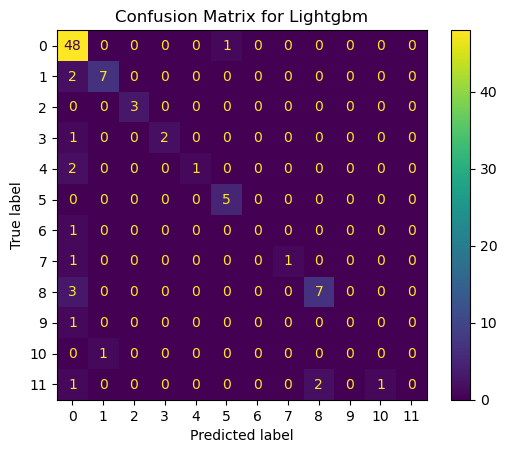

In [16]:

from sklearn import metrics
lgbmconfusionmatrix=confusion_matrix(y_test,lgbm_pred)
print(lgbmconfusionmatrix)

display = metrics.ConfusionMatrixDisplay(confusion_matrix = lgbmconfusionmatrix)
display.plot()
plt.title('Confusion Matrix for Lightgbm')
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuacy of SVM: 78.26086956521739
Accuacy of MLP: 80.43478260869566
Accuacy of KNN: 71.73913043478261
Accuacy of RFC: 86.95652173913044
Accuacy of NB: 8.695652173913043
Accuacy of lgbm: 82.6086956521739


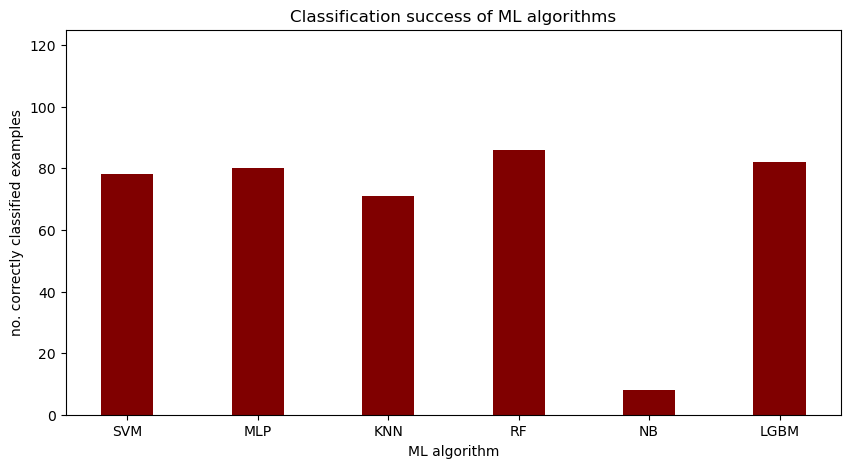

Kappa score of SVM: 0.6477794793261868
Kappa score of MLP: 0.6940133037694013
Kappa score KNN: 0.5276461295418642
Kappa score RFC: 0.798687089715536
Kappa score NB: -0.01098901098901095
Kappa score lgbm: 0.7192982456140351


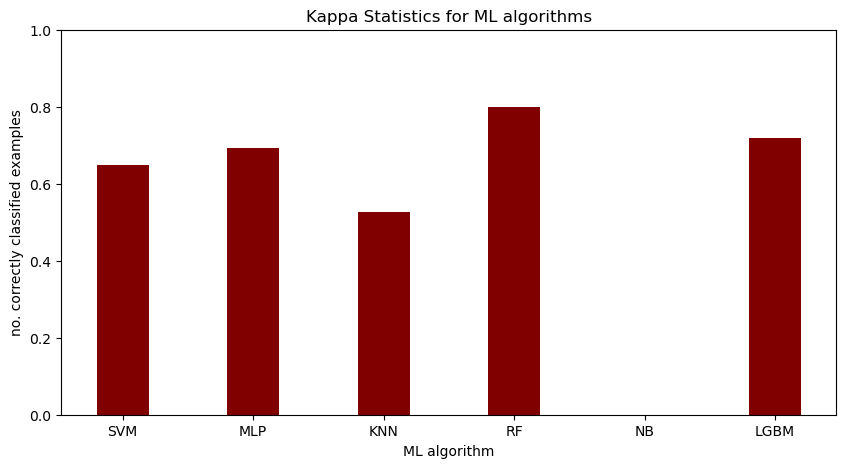

SVM_report 
               precision    recall  f1-score   support

         1.0       0.80      0.96      0.87        25
         2.0       0.75      0.75      0.75         4
         3.0       1.00      1.00      1.00         2
         4.0       0.50      0.50      0.50         2
         5.0       0.00      0.00      0.00         1
         6.0       0.00      0.00      0.00         3
         9.0       1.00      1.00      1.00         1
        10.0       0.71      1.00      0.83         5
        15.0       0.00      0.00      0.00         1
        16.0       0.00      0.00      0.00         2

    accuracy                           0.78        46
   macro avg       0.48      0.52      0.50        46
weighted avg       0.66      0.78      0.72        46

KNN_report 
               precision    recall  f1-score   support

         1.0       0.72      0.92      0.81        25
         2.0       0.60      0.75      0.67         4
         3.0       1.00      1.00      1.00         

In [11]:
# classification models for train test split as 90:10

svm_t = SVC(C=16,kernel="rbf",gamma=0.001,random_state=42,decision_function_shape='ovr').fit(x_train1, y_train1)

mlp_classifier = MLPClassifier(hidden_layer_sizes=(279), activation='tanh', solver='sgd', learning_rate='constant', random_state=42)
mlp_classifier.fit(x_train1, y_train1)

knn_t = KNeighborsClassifier(n_neighbors=3) .fit(x_train1, y_train1)

rfc_t = RandomForestClassifier(criterion= 'gini', n_estimators=100, random_state=42).fit(x_train1, y_train1)

lgbm_classifier = lgb.LGBMClassifier(n_estimators=100, random_state=42).fit(x_train1,y_train1)

nb_model = GaussianNB().fit(x_train1,y_train1)


svm_pred = svm_t.predict(x_test1)
knn_pred = knn_t.predict(x_test1)
MLP_pred = mlp_classifier.predict(x_test1)
rfc_pred = rfc_t.predict(x_test1)
nb_pred=nb_model.predict(x_test1)
lgbm_pred=lgbm_classifier.predict(x_test1)

svm_acc = accuracy_score(y_test1, svm_pred)*100
knn_acc = accuracy_score(y_test1, knn_pred)*100
MLP_acc=accuracy_score(y_test1, MLP_pred)*100
rfc_acc = accuracy_score(y_test1, rfc_pred)*100
nb_acc = accuracy_score(y_test1,nb_pred)*100
lgbm_acc=accuracy_score(y_test1,lgbm_pred)*100

print ("Accuacy of SVM:",svm_acc)
print("Accuacy of MLP:", MLP_acc)
print ("Accuacy of KNN:", knn_acc)
print ("Accuacy of RFC:",rfc_acc)
print("Accuacy of NB:",nb_acc)
print("Accuacy of lgbm:",lgbm_acc)

bar_data = dict()
bar_data['SVM'] = int(svm_acc)
bar_data['MLP'] = int(MLP_acc)
bar_data['KNN'] = int(knn_acc)
bar_data['RF'] = int(rfc_acc)
bar_data['NB'] = int(nb_acc)
bar_data['LGBM'] = int(lgbm_acc)


algs = list(bar_data.keys())
values = list(bar_data.values())

fig = plt.figure(figsize = (10, 5))
plt.ylim(top=125)
plt.bar(algs, values, color ='maroon',
        width = 0.4)

plt.xlabel("ML algorithm")
plt.ylabel("no. correctly classified examples")
plt.title("Classification success of ML algorithms")
plt.show()


# Kappa Statistics
svm_Kappa = cohen_kappa_score(y_test1, svm_pred)
knn_kappa = cohen_kappa_score(y_test1, knn_pred)
MLP_kappa=cohen_kappa_score(y_test1, MLP_pred)
rfc_kappa = cohen_kappa_score(y_test1, rfc_pred)
nb_kappa = cohen_kappa_score(y_test1,nb_pred)
lgbm_kappa=cohen_kappa_score(y_test1,lgbm_pred)

print ("Kappa score of SVM:",svm_Kappa)
print("Kappa score of MLP:", MLP_kappa)
print ("Kappa score KNN:", knn_kappa)
print ("Kappa score RFC:",rfc_kappa)
print("Kappa score NB:",nb_kappa)
print("Kappa score lgbm:",lgbm_kappa)

bar_data = dict()
bar_data['SVM'] = float(svm_Kappa)
bar_data['MLP'] = float(MLP_kappa)
bar_data['KNN'] = float(knn_kappa)
bar_data['RF'] = float(rfc_kappa)
bar_data['NB'] = float(nb_kappa)
bar_data['LGBM'] = float(lgbm_kappa)


algs = list(bar_data.keys())
values = list(bar_data.values())

fig = plt.figure(figsize = (10, 5))
plt.ylim(top=1)
plt.bar(algs, values, color ='maroon',
        width = 0.4)

plt.xlabel("ML algorithm")
plt.ylabel("no. correctly classified examples")
plt.title("Kappa Statistics for ML algorithms")
plt.show()

# classification report
SVM_report= classification_report (y_test1, svm_pred)
knn_report = classification_report(y_test1, knn_pred)
MLP_report=classification_report(y_test1, MLP_pred)
rfc_report = classification_report(y_test1, rfc_pred)
nb_report= classification_report(y_test1,nb_pred)
lgbm_report=classification_report(y_test1,lgbm_pred)

print("SVM_report \n",SVM_report)

print("KNN_report \n",knn_report)

print("MLP_report \n",MLP_report)

print("RFC_report \n",rfc_report)

print("NB_report \n",nb_report)

print("lgbm_report \n",lgbm_report)




/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=30.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=30.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=30.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn'

Cross validation score of SVM: 0.5422222222222222
Cross validation score of MLP: 0.6459722222222223
Cross validation score of KNN: 0.6105555555555554
Cross validation score of RFC: 0.7613888888888891
Cross validation score of NB: 0.4575000000000001
Cross validation score of lgbm: 0.750277777777778


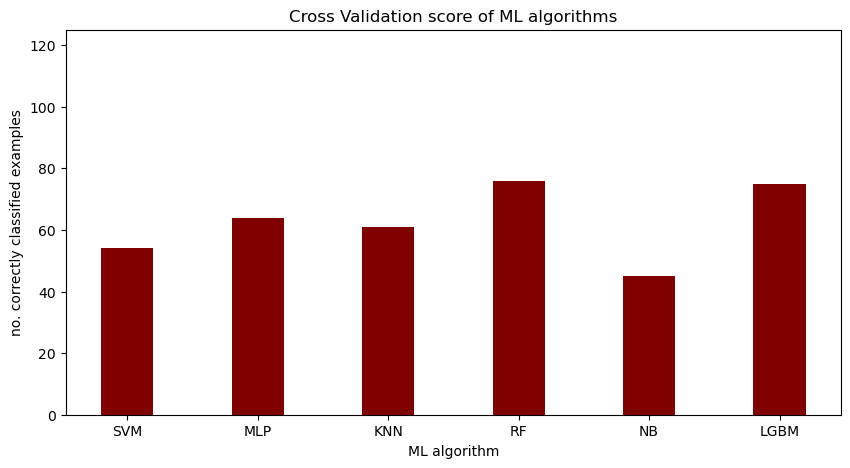

In [16]:
# cross val score of classification models
lgbm_score=cross_val_score(lgbm_classifier,kbestfeatures,y,cv=30,scoring='accuracy').mean()
svm_score=cross_val_score(svm_t,kbestfeatures,y,cv=30,scoring='accuracy').mean()
mlp_score=cross_val_score(mlp_classifier,kbestfeatures,y,cv=30,scoring='accuracy').mean()
knn_score=cross_val_score(knn_t,kbestfeatures,y,cv=30,scoring='accuracy').mean()
rfc_score=cross_val_score(rfc_t,kbestfeatures,y,cv=30,scoring='accuracy').mean()
nb_score=cross_val_score(nb_model,kbestfeatures,y,cv=30,scoring='accuracy').mean()


print ("Cross validation score of SVM:",svm_score)
print("Cross validation score of MLP:", mlp_score)
print ("Cross validation score of KNN:", knn_score)
print ("Cross validation score of RFC:",rfc_score)
print("Cross validation score of NB:",nb_score)
print("Cross validation score of lgbm:",lgbm_score)

bar_data = dict()
bar_data['SVM'] = int(svm_score * 100)
bar_data['MLP'] = int(mlp_score *100)
bar_data['KNN'] = int(knn_score * 100)
bar_data['RF'] = int(rfc_score * 100)
bar_data['NB'] = int(nb_score *100)
bar_data['LGBM'] = int(lgbm_score *100)


algs = list(bar_data.keys())
values = list(bar_data.values())

fig = plt.figure(figsize = (10, 5))
plt.ylim(top=125)
plt.bar(algs, values, color ='maroon',
        width = 0.4)

plt.xlabel("ML algorithm")
plt.ylabel("no. correctly classified examples")
plt.title("Cross Validation score of ML algorithms")
plt.show()

In [ ]:
rfc=RandomForestClassifier()
#parameters = {'n_estimators': [10, 20, 30, 40], 'max_features': ['sqrt', 'log2'], 'max_depth' : [6, 7, 8, 9], 'criterion' :['gini', 'entropy', 'log_loss'], 'min_samples_leaf':[1, 2, 3]} # daje 0.59 accuracy s najboljim parametrima
parameters={'max_depth':[100, 150, 200, 250], 'n_estimators':[10, 20, 30, 40, 50], 'min_samples_leaf':[1, 2, 3, 4]}
rfc_gs = GridSearchCV(estimator=rfc, param_grid=parameters, cv=10)
rfc_gs.fit(x_train, y_train)

print("best hyperparameters: ", rfc_gs.best_params_)
print("accuracy with the best parameters: ", rfc_gs.best_score_)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 'gamma': [0.1, 0.01, 0.001, 0.0009, 0.0005, 0.0001]}
svm = SVC()

svm_gs = GridSearchCV(svm, parameters)
svm_gs.fit(x_train, y_train)
GridSearchCV(estimator=SVC(), param_grid=parameters, scoring='accuracy', cv=10)

print("best hyperparameters: ", svm_gs.best_params_)
print("accuracy with the best parameters: ", svm_gs.best_score_)

In [ ]:

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
k_range = list(range(1, 31))
#parameters = dict(n_neighbors=k_range)
parameters={'metric':('manhattan','euclidean','chebyshev','minkowski'),
            'n_neighbors':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],'weights':('uniform','Distance'),
           'algorithm':('auto','ball_tree','kd_tree','brute'), 'p':[1,2]}

knn_gs = GridSearchCV(knn, parameters, cv=10, scoring='accuracy')

knn_gs.fit(x_train, y_train)

print("best hyperparameters: ", knn_gs.best_params_)
print("accuracy with the best parameters: ", knn_gs.best_score_)

In [7]:
lgbm_classifier = lgb.LGBMClassifier(n_estimators=100, random_state=42)
#Stratified k-fold#
#Normalize the features selected from Original Dataset#
scaler= StandardScaler()
kbestfeatures=scaler.fit_transform(kbestfeatures)

# Labelling#
X = kbestfeatures  # Features
y = y    # Target labels

# Number of desired folds (k)
n_splits = 30

# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Iterate through the splits
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Replace the following with your model training and evaluation code
    # For example, you can train your model on X_train and y_train and evaluate it on X_test and y_test
    model= lgbm_classifier.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    
    # Print or store the evaluation results
    print("Model Score",accuracy.mean())



/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=30.
  warnings.warn(


Model Score 0.5625
Model Score 0.625
Model Score 0.8
Model Score 0.6666666666666666
Model Score 0.8
Model Score 0.8666666666666667
Model Score 0.8
Model Score 0.8
Model Score 0.7333333333333333
Model Score 0.7333333333333333
Model Score 0.8666666666666667
Model Score 0.8666666666666667
Model Score 0.8
Model Score 0.6666666666666666
Model Score 0.8
Model Score 0.8666666666666667
Model Score 0.6
Model Score 0.7333333333333333
Model Score 0.8666666666666667
Model Score 0.8
Model Score 0.6666666666666666
Model Score 0.8
Model Score 0.7333333333333333
Model Score 0.7333333333333333
Model Score 0.6666666666666666
Model Score 0.7333333333333333
Model Score 0.7333333333333333
Model Score 0.4666666666666667
Model Score 0.6
Model Score 0.8666666666666667


In [10]:
print('Model Score for LightGBM',accuracy.mean())

Model Score for LightGBM 0.8666666666666667
